In [1]:
import numpy as np
from numpy.linalg import eigh
from matplotlib import pyplot as plt
import matplotlib
import tfim_1d
import generate_cdf
from qcels import *
import qiskit
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

In [2]:
num_sites = 4
J = 1.0
g = 4.0

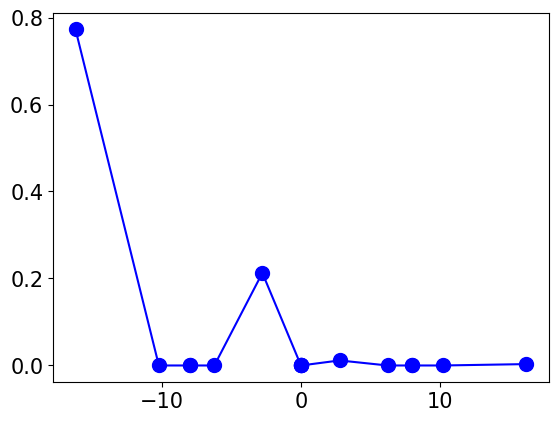

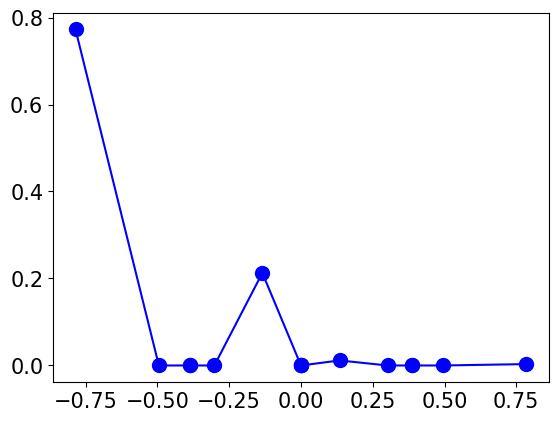

In [3]:
# move this somewhere else
def modify_spectrum(ham):
    arr_ham = ham.toarray()
    arr_ham = arr_ham.astype(np.complex128)
    n = len(arr_ham[0])
    eigenenergies, _ = ham.eigh(subset_by_index = (n-1,n-1))
    max_eigenvalue = eigenenergies[0]
    norm_ham = (ham_shift)*arr_ham/max_eigenvalue
    return norm_ham

# calculate the ground state with g = 1
ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigh(subset_by_index = (0,0))[1][:,0]


# plot original spectrum
ham = tfim_1d.generate_ham(num_sites, J, g)
eigenenergies, eigenstates = ham.eigh()
ground_state = eigenstates[:,0]
population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population_raw, 'b-o')
plt.show()

old_ham = ham

# create modified spectrum
ham = modify_spectrum(old_ham)
eigenenergies, eigenstates = eigh(ham)
ground_state = eigenstates[:,0]
population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population, 'b-o')
plt.show()

In [4]:
computation_type = 'S'
output_file = True

p0_array            = np.array([0.6,0.8]) # initial overlap with the first eigenvector
deltas              = 1*np.sqrt(1 - p0_array) # QCELS sec A pg. 3
trials              = 5 # number of comparisions each test (circuit depths)
tests               = 1
err_threshold       = 0.01
T0                  = 100

# QCELS variables
# T_list_QCELS      = 10+T0/2*(np.arange(trials)) # circuit depth for QCELS
time_steps          = 5
err_QCELS           = np.zeros((len(p0_array),trials))
cost_list_avg_QCELS = np.zeros((len(p0_array),trials))
rate_success_QCELS  = np.zeros((len(p0_array),trials))
max_T_QCELS         = np.zeros((len(p0_array),trials))

# QPE variables
# T_list_QPE        = 10+T0*4*(np.arange(trials)) # circuit depth for QPE
err_QPE             = np.zeros((len(p0_array),trials))
cost_list_avg_QPE   = np.zeros((len(p0_array),trials))
rate_success_QPE    = np.zeros((len(p0_array),trials))
QPE_depths          = np.zeros(trials)

In [5]:
# set computation type to T (Theoretical Simulation), S (Quantum Simulation), or R (Quantum Hardware)
# initialization

if computation_type[0].upper() == 'T':
    print("\nTHEORETICAL SIMULATION SELECTED\n")

    T_list_QCELS = 10+T0/2*(np.arange(trials))
    T_list_QPE = 10+T0*4*(np.arange(trials))

    data_name = "T_Sim"

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION SELECTED\n")

    #T_list_QCELS = np.arange(trials) + 1
    #T_list_QPE = np.arange(trials) + 1
    #epsilons = np.array([10**(-i-1) for i in range(trials)])
    epsilons = np.linspace(0.4,0.1, trials)
    #epsilons = np.array([0.063, 3/8, 1, 1, 1])
    #iterations = [int(np.ceil(1/i) + 1) for i in epsilons]
    

    T_list_QCELS = 10+T0/2*(np.arange(trials))
    iterations = [int(np.log2(i/time_steps)) for i in T_list_QCELS]
    #T_list_QPE = 10+T0*4*(np.arange(trials))

    #iterations=np.array([int(np.log2(i/time_steps)) for i in T_list_QCELS])
    #iterations = 3*np.arange(trials) + 1

    backend = AerSimulator()
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE SELECTED\n")

    T_list_QCELS = 10+T0/2*(np.arange(trials))
    #T_list_QPE = 10+T0*4*(np.arange(trials))
    #iterations=np.array([int(np.log2(i/time_steps)) for i in T_list_QCELS])
    #epsilons = np.array([10**(-i-1) for i in range(trials)])
    
    #iterations = [int(np.ceil(1/i) + 1) for i in epsilons]
    
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    from qiskit_ibm_runtime import QiskitRuntimeService as QRS
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
    data_name = "Q_Real"

if output_file:
    outfile = open("Output/"+str(data_name)+"_trans.txt", 'w')



QUANTUM SIMULATION SELECTED



In [6]:
# Transpiles circuits

from qiskit_ibm_runtime import SamplerV2 as Sampler
if computation_type[0].upper() != 'T':
    for p in range(len(p0_array)):
        p0=p0_array[p]
        delta = deltas[p]
        n_success_QCELS= np.zeros(trials)
        n_success_QPE= np.zeros(trials)

        print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

        if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

        for test in range(tests):

            print("  Generating QCELS and QPE circuits", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

            spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])
            print('Ground State: ', spectrum[0])

            #------------------QCELS-----------------
            Nsample = 100 # number of samples for constructing the loss function

            for trial in range(trials):
                print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")")
                epsilon = epsilons[trial]

                if output_file: print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
                T = T_list_QCELS[trial]
                for j in range(iterations[trial] + 1):
                    print('old', T/time_steps/(2**(iterations[trial]-j)), T/time_steps/(2**(iterations[trial])))
                    tau = get_tau(j, epsilon, delta, time_steps, iterations[trial], T)
                    print('new', tau)
                    qcs_QCELS = []
                    for data_pair in range(time_steps):
                        t = tau*data_pair
                        qcs_QCELS.append(create_HT_circuit(ham, t, W = 'Re', p0 = p0, backend = backend))
                        qcs_QCELS.append(create_HT_circuit(ham, t, W = 'Im', p0 = p0, backend = backend))
                    with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Test'+str(test)+'_Trial'+str(trial)+'_Iter='+str(j)+'.qpy', 'wb') as f:
                        qiskit.qpy.dump(qcs_QCELS, f)
            print('Finished transpiling for QCELS test '+str(test + 1))


        # ----------------- QPE -----------------------
            # N_try_QPE = int(15*np.ceil(1.0/p0)) #number of QPE samples each time

            # for trial in range(trials):
            #     print("    Transpiling QPE", "("+str(trial + 1)+"/"+str(trials)+")", flush = True)
            #     if output_file: print("    Transpiling QPE", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush=True)
                
            #     T = T_list_QPE[trial]
                
            #     qc_QPE = create_QPE_circuit(ham, np.ceil(np.log2(T)), p0 = p0, backend = backend)
            #     QPE_depth = qc_QPE.depth()

            #     with open('Transpiled_Circuits/QPE_p0='+str(p0)+'_Test'+str(test)+'_Trial'+str(trial)+'.qpy', 'wb') as f:
            #         qiskit.qpy.dump(qc_QPE, f)
            # print('Finished transpiling for QPE test '+str(test + 1))   


Testing p0 = 0.6 (1/2)
  Generating QCELS and QPE circuits (p0=0.6) (1/1)
Ground State:  -0.7853981633974482
    Transpiling QCELS (1/5)
old 1.0 1.0
new 2.0
old 2.0 1.0
new 4.0
    Transpiling QCELS (2/5)
old 1.5 1.5
new 3.0
old 3.0 1.5
new 6.0
old 6.0 1.5
new 12.0
old 12.0 1.5
new 24.0
    Transpiling QCELS (3/5)
old 1.375 1.375
new 2.75
old 2.75 1.375
new 5.5
old 5.5 1.375
new 11.0
old 11.0 1.375
new 22.0
old 22.0 1.375
new 44.0
    Transpiling QCELS (4/5)
old 1.0 1.0
new 2.0
old 2.0 1.0
new 4.0
old 4.0 1.0
new 8.0
old 8.0 1.0
new 16.0
old 16.0 1.0
new 32.0
old 32.0 1.0
new 64.0
    Transpiling QCELS (5/5)
old 1.3125 1.3125
new 2.625
old 2.625 1.3125
new 5.25
old 5.25 1.3125
new 10.5
old 10.5 1.3125
new 21.0
old 21.0 1.3125
new 42.0
old 42.0 1.3125
new 84.0
Finished transpiling for QCELS test 1
Testing p0 = 0.8 (2/2)
  Generating QCELS and QPE circuits (p0=0.8) (1/1)
Ground State:  -0.7853981633974482
    Transpiling QCELS (1/5)
old 1.0 1.0
new 2.0
old 2.0 1.0
new 4.0
    Transpiling

In [7]:
# Loads and runs transpiled circuits and saves related data
QCELS_depths = []

if computation_type[0].upper() == 'T':
    generate_Z_theory()

else:
    qcs_QCELS = []

    for p in range(len(p0_array)):
        p0 = p0_array[p]
        QCELS_depths.append([])
        for test in range(tests):
            QCELS_depths[p].append([])
            for trial in range(trials):
                depth = 0
                print('Loading QCELS data ('+str(trial+1)+'/'+str(trials)+')')
                for i in range(-1, iterations[trial]):
                    with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Test'+str(test)+'_Trial'+str(trial)+'_Iter='+str(i)+'.qpy', 'rb') as f:
                        circs = qiskit.qpy.load(f)
                        for time_step in range(time_steps):
                            depth += circs[time_step].depth() 
                        qcs_QCELS.append(circs)

                QCELS_depths[p][test].append(depth)

    qcs_QCELS = sum(qcs_QCELS, []) # flatten list

    print('Running transpiled circuits')
    sampler = Sampler(backend)
    jobs = sampler.run(qcs_QCELS, shots = T0)
    results = jobs.result()


Loading QCELS data (1/5)
Loading QCELS data (2/5)
Loading QCELS data (3/5)
Loading QCELS data (4/5)
Loading QCELS data (5/5)
Loading QCELS data (1/5)
Loading QCELS data (2/5)
Loading QCELS data (3/5)
Loading QCELS data (4/5)
Loading QCELS data (5/5)
Running transpiled circuits


In [8]:
Z_ests = []
QCELS_times = []
for p in range(len(p0_array)):
    Z_ests.append([])
    QCELS_times.append([])
    for test in range(tests):
        Z_ests[p].append([])
        QCELS_times[p].append([])
        for trial in range(trials):
            exec_time = 0
            Z_ests[p][test].append([])
            for iter in range(iterations[trial] + 1):
                Z_ests[p][test][trial].append([])
                for time_step in range(time_steps):
                    index = time_step*2 + iter*time_steps*2 + (sum(iterations[0:trial])+trial)*time_steps*2 + test*(sum(iterations)+len(iterations))*time_steps*2 + p*tests*(sum(iterations)+len(iterations))*time_steps*2
                    raw_data_re = results[index].data
                    counts_re = raw_data_re[list(raw_data_re.keys())[0]].get_counts()
                    raw_data_im = results[index + 1].data
                    counts_im = raw_data_im[list(raw_data_im.keys())[0]].get_counts()
                    exec_time += (0 + 1)

                    re_p0 = im_p0 = 0
                    if counts_re.get('0') is not None:
                        re_p0 = counts_re['0']/T0
                    if counts_im.get('0') is not None:
                        im_p0 = counts_im['0']/T0
                    
                    Re = 2*re_p0-1
                    Im = 2*im_p0-1 

                    Angle = np.arccos(Re)
                    if  np.arcsin(Im)<0:
                        Phase = 2*np.pi - Angle
                    else:
                        Phase = Angle

                    Z_est = complex(np.cos(Phase),np.sin(Phase))
                    
                    Z_ests[p][test][trial][iter].append(Z_est)
            QCELS_times[p][test].append(exec_time)

In [9]:
def QPE_Est():
    if computation_type[0].upper() == 'T':
        discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi
        dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
        samp = generate_cdf.draw_with_prob(dist,N_try_QPE) # uses dist with counts to get samp
        j_min = samp.min()
        result = discrete_energies[j_min], T_list_QPE[trial]

    if computation_type[0].upper() == 'S':
        result = generate_QPE_sampling_ham(ham, Nsample, 2*T, p0 = p0)

    if computation_type[0].upper() == 'R':
        result = generate_QPE_sampling_ham(ham, Nsample, 2*T, p0 = p0)
    return result

if output_file:
    outfile = open("Output/"+str(data_name)+"_run.txt", 'w')

for p in range(len(p0_array)):
    p0=p0_array[p]
    delta = deltas[p]
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS and QPE data", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

        spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        Nsample = 100 # number of samples for constructing the loss function

        for trial in range(trials):
            print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")")

            if output_file: print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            epsilon = epsilons[trial]
            T = T_list_QCELS[trial]
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS = qcels_largeoverlap_new(Z_ests[p][test][trial], time_steps, lambda_prior, delta, epsilon, T)
            #ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = qcels_largeoverlap()
            
            cosT_depth_list_this = QCELS_depths[p][test][trial]
            max_T_QCELS_this = 0

            print("      Estimated ground state energy =", ground_energy_estimate_QCELS)
            if output_file: print("      Estimated ground state energy =", ground_energy_estimate_QCELS.x[2], file = outfile)

            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - spectrum[0])
            err_QCELS[p,trial] = err_QCELS[p,trial]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[p,trial]=cost_list_avg_QCELS[p,trial]+cosT_depth_list_this
            max_T_QCELS[p,trial]=max(max_T_QCELS[p,trial],max_T_QCELS_this)

            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[trial]+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

       # ----------------- QPE -----------------------
        # N_try_QPE = int(15*np.ceil(1.0/p0)) #number of QPE samples each time

        # for trial in range(trials):
        #     print("    Running QPE", "("+str(trial+1)+"/"+str(trials)+")", flush = True)
        #     if output_file: print("    Running QPE", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush=True)
            
        #     T = T_list_QPE[trial]
            
        #     ground_energy_estimate_QPE, QPE_depth = QPE_Est()
        #     print(QPE_depth)

        #     print("      Estimated ground state energy =", ground_energy_estimate_QPE)
        #     if output_file: print("      Estimated ground state energy =", ground_energy_estimate_QPE, file = outfile)

        #     err_this_ruN_test = np.abs(ground_energy_estimate_QPE-spectrum[0])
        #     err_QPE[p,trial] = err_QPE[p,trial]+np.abs(err_this_ruN_test)

        #     if np.abs(err_this_ruN_test)<err_threshold:
        #         n_success_QPE[trial]+=1
        #     #cost_list_avg_QPE[p,trial] = T*N_try_QPE
        #     cost_list_avg_QPE[p,trial] = QPE_depth

        # print("    Finished QPE data\n")
        # if output_file: print("    Finished QPE data\n", file = outfile)

    rate_success_QCELS[p,:] = n_success_QCELS[:]/tests
    #rate_success_QPE[p,:] = n_success_QPE[:]/tests
    err_QCELS[p,:] = err_QCELS[p,:]/tests
    #err_QPE[p,:] = err_QPE[p,:]/tests
    cost_list_avg_QCELS[p,:]=cost_list_avg_QCELS[p,:]/tests

#np.savez('Data/'+data_name+'_result_TFIM_8sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
np.savez('Data/'+data_name+'_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS)
np.savez('Data/'+data_name+'_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")


Testing p0 = 0.6 (1/2)
  Generating QCELS and QPE data (p0=0.6) (1/1)
    Running QCELS (1/5)
1
      Preprocessing
      Starting Iteration (1/1)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.11223576201534557
       x: [ 8.630e-01  3.776e-01 -1.908e+00]
     nit: 10
     jac: [-3.419e-04 -1.901e-04  3.271e+00]
    nfev: 43
    njev: 10
    Running QCELS (2/5)
3
      Preprocessing
      Starting Iteration (1/3)
      Starting Iteration (2/3)
      Starting Iteration (3/3)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.013083423814796814
       x: [ 9.926e-01 -3.947e-02 -1.439e+00]
     nit: 5
     jac: [ 8.339e-04 -4.344e-04 -2.901e-02]
    nfev: 25
    njev: 5
    Running QCELS (3/5)
4
      Preprocessing
      Starting Iteration (1/4)
      Starting Iteration (2/4)
      Startin